In [249]:
import json
import ufl
import dolfin as dl

#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

from helpers import *
from generate_samples import *
from train_nn import *



In [250]:
nx =63; ny = 63
nodes = (nx+1)*(ny+1)
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)
#f = dl.Expression("sin(2*pi*x[0]) * exp(x[1]+ x[0])", degree=5)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx
    

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


In [251]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable = hf.LinearStateObservable(pde,I_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy


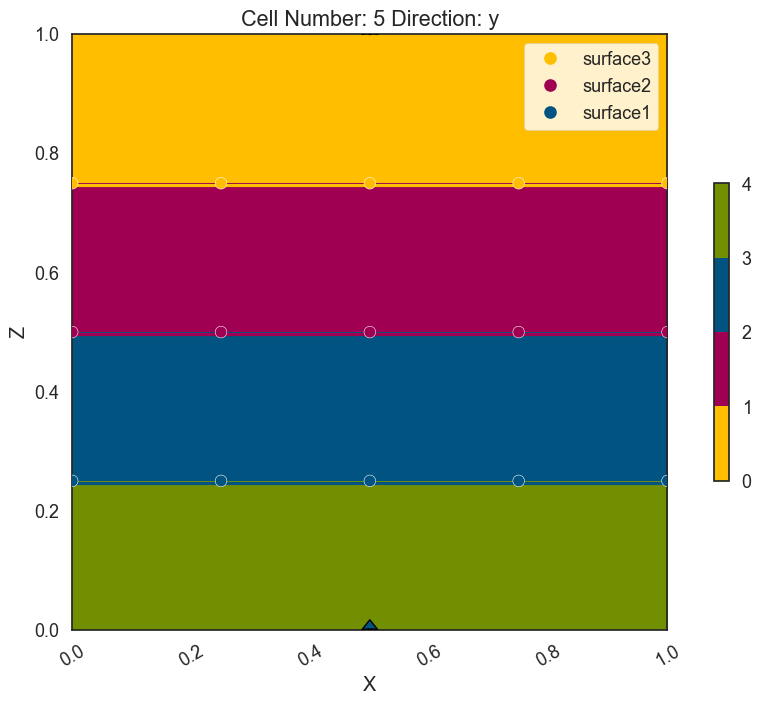

In [252]:
m_initial, sp_coords_copy_test, gempy_model= create_true_data(mesh=mesh, nodes=nodes, filename=None)

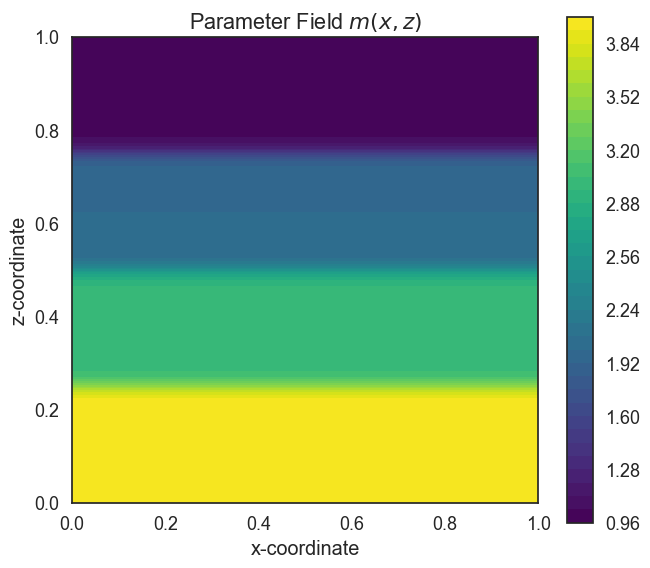

In [253]:
m = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_initial[d2v])
# plt.axis("off")
col = dl.plot(m,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("Parameter Field $m(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)

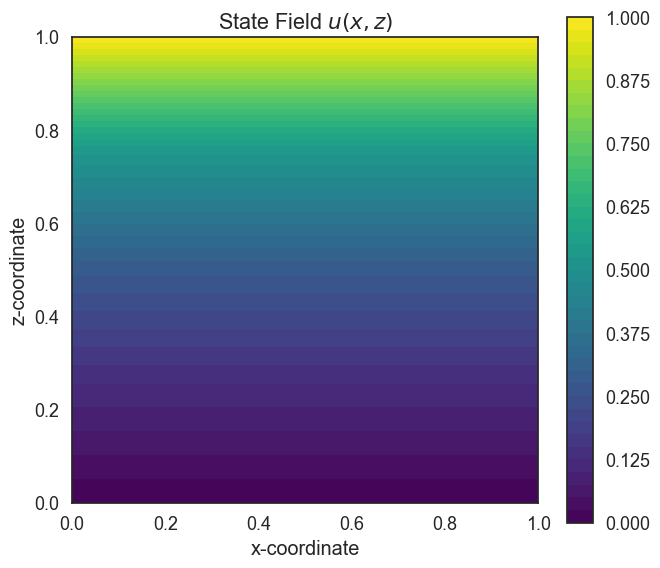

In [254]:
u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])
x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)
# Get the data
u_true = x[hp.STATE].get_local()
# plot u_true
u.vector().set_local(u_true)
# plt.axis("off")
col = dl.plot(u,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("State Field $u(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)


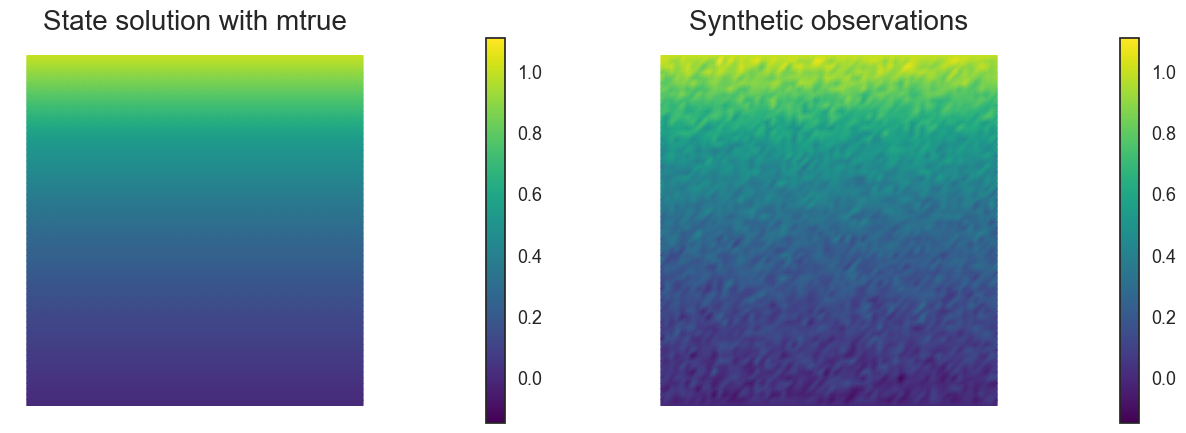

In [255]:
# noise level
noise_level = 0.05


ud = dl.Function(Vh[hp.STATE])
ud.assign(u)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")

# Create noise vector and insert the numpy array
noise = dl.Vector()
M_U.init_vector(noise, 1)
hp.parRandom.normal(noise_level * MAX, noise)

bc0.apply(noise)

ud.vector().axpy(1., noise)

# plot
hp.nb.multi1_plot([u, ud], ["State solution with mtrue", "Synthetic observations"])
# Add axis labels and title

plt.show()


In [256]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype =torch.float32
Mph= torch.tensor(np.load('./saved_model/Mphi.npy'), dtype=dtype, device=device)
phi = torch.tensor(np.load('./saved_model/phi.npy'), dtype=dtype, device=device)
u_shift = torch.tensor(np.load('./saved_model/u_shift.npy'), dtype=dtype, device=device)


In [257]:
# Load the full model directly
model_without_jacobian = torch.load("./saved_model/model_without_jacobian.pth",weights_only=False)
model_jacobian_full    = torch.load("./saved_model/model_jacobian_full.pth", weights_only=False)
model_jacobian_truncated    = torch.load("./saved_model/model_jacobian_truncated.pth", weights_only=False)


In [258]:
def pyro_model(interpolation_input_ ,num_layers, NN_model, u_shift, phi, obs_data, device ):
        
            """
            This Pyro model represents the probabilistic aspects of the geological model.
            It defines a prior distribution for the top layer's location and
            computes the thickness of the geological layer as an observed variable.

            
            interpolation_input_: represents the dictionary of random variables for surface parameters
            
            num_layers: represents the number of layers we want to include in the model
            
            """

            
            parameter = []
            
            # Create a random variable based on the provided dictionary used to modify input data of gempy
            counter=1
            for interpolation_input_data in interpolation_input_[:num_layers]:
                
                # Check if user wants to create random variable based on modifying the surface points of gempy
                if interpolation_input_data["update"]=="interface_data":
                    # Check what kind of distribution is needed
                    if interpolation_input_data["prior_distribution"]=="normal":
                        mean = interpolation_input_data["normal"]["mean"]
                        std  = interpolation_input_data["normal"]["std"]
                        parameter.append(pyro.sample("mu_"+ str(counter), dist.Normal(mean, std)))
                        
                    elif interpolation_input_data["prior_distribution"]=="uniform":
                        min = interpolation_input_data["uniform"]["min"]
                        max = interpolation_input_data["uniform"]["min"]
                        parameter.append(pyro.sample("mu_"+ str(interpolation_input_data['id']), dist.Uniform(min, max)))

                        
                    else:
                        print("We have to include the distribution")
                
                counter=counter+1
                
            input_data = torch.tensor(parameter, device=device)
            NN_model.eval()
            NN_output = NN_model(input_data)
            output =torch.matmul(phi , NN_output) + u_shift
            with pyro.plate("likelihood", obs_data.shape[0]):
                pyro.sample("obs", dist.Normal(output, 5), obs=obs_data)
            
            

In [259]:
###############################################################################
# Make a list of gempy parameter which would be treated as a random variable
###############################################################################

test_list=[]
std = 0.03
test_list.append({"update":"interface_data","id":torch.tensor([1]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[1,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([2]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[2,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([3]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[3,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([6]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[6,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([7]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[7,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([8]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[8,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([11]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[11,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([12]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[12,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([13]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[13,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
num_layers = len(test_list) 


In [260]:
model = model_jacobian_full

In [261]:
obs_data = torch.tensor(ud.vector().get_local(), dtype=dtype, device=device)
dot = pyro.render_model(pyro_model, model_args=(test_list, num_layers, model,  u_shift, phi, obs_data , device),render_distributions=True)

/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'mu_1'}>,
        <Axes: title={'center': 'mu_1'}>],
       [<Axes: title={'center': 'mu_2'}>,
        <Axes: title={'center': 'mu_2'}>],
       [<Axes: title={'center': 'mu_3'}>,
        <Axes: title={'center': 'mu_3'}>],
       [<Axes: title={'center': 'mu_4'}>,
        <Axes: title={'center': 'mu_4'}>],
       [<Axes: title={'center': 'mu_5'}>,
        <Axes: title={'center': 'mu_5'}>],
       [<Axes: title={'center': 'mu_6'}>,
        <Axes: title={'center': 'mu_6'}>],
       [<Axes: title={'center': 'mu_7'}>,
        <Axes: title={'center': 'mu_7'}>],
       [<Axes: title={'center': 'mu_8'}>,
        <Axes: title={'center': 'mu_8'}>],
       [<Axes: title={'center': 'mu_9'}>,
        <Axes: title={'center': 'mu_9'}>],
       [<Axes: title={'center': 'obs'}>, <Axes: title={'center': 'obs'}>]],
      dtype=object)

<Figure size 800x1000 with 0 Axes>

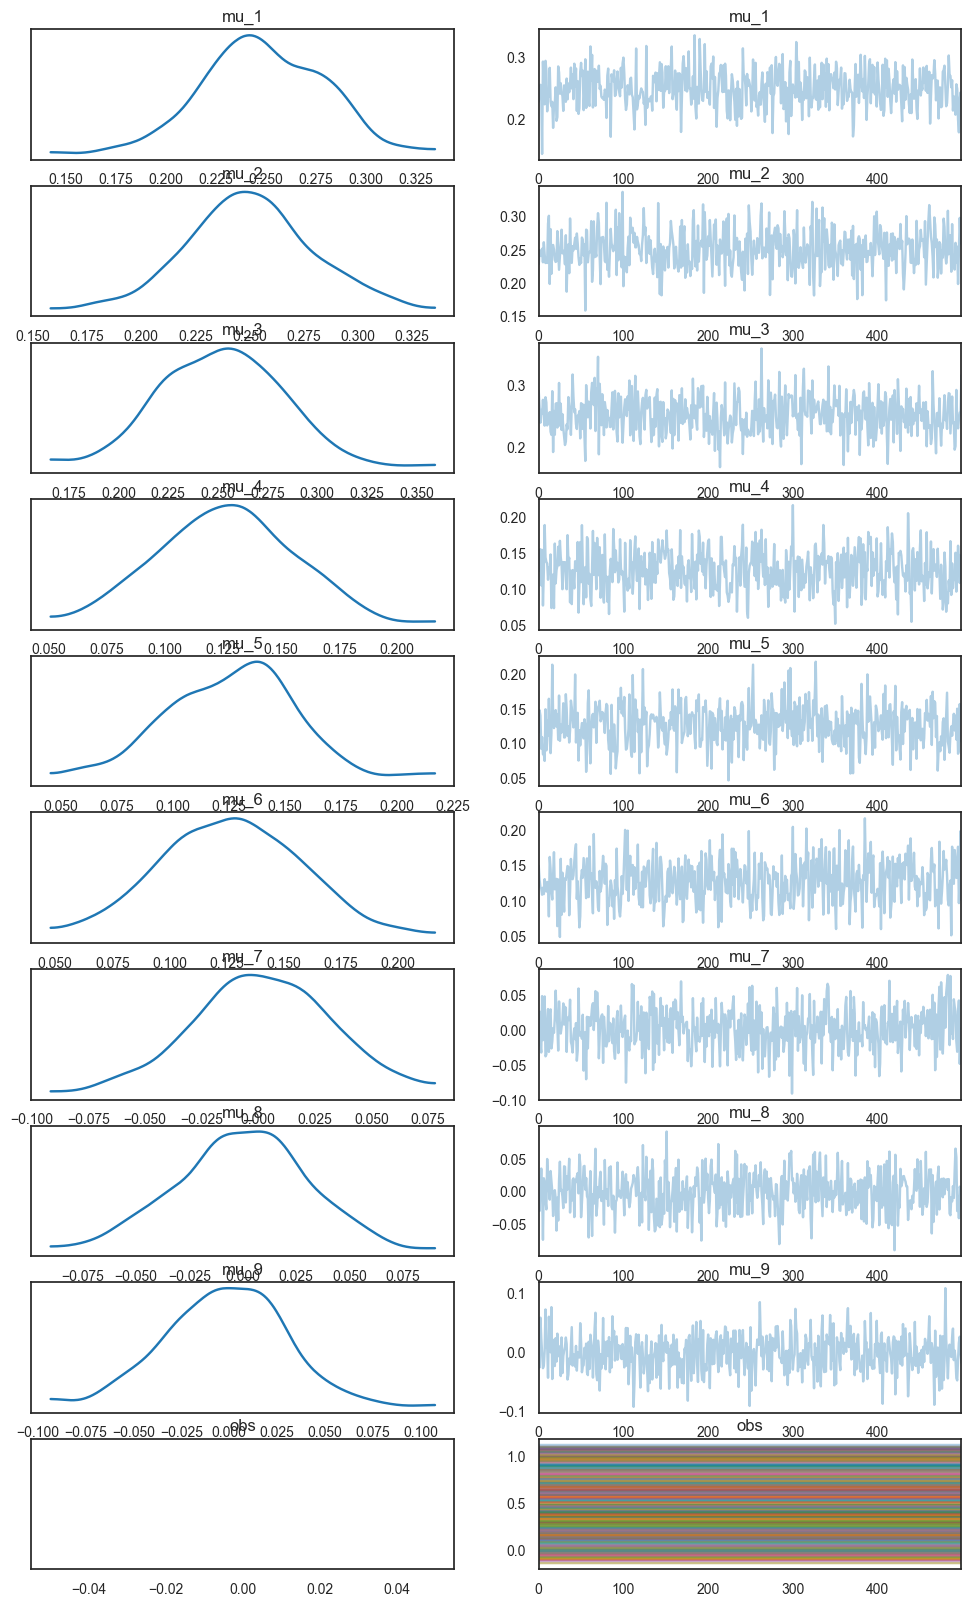

In [262]:
pyro.set_rng_seed(42)
import arviz as az
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
prior = Predictive(pyro_model,num_samples=500)(test_list, num_layers, model,  u_shift, phi, obs_data , device)
plt.figure(figsize=(8,10))
data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)

In [263]:
################################################################################
# Posterior
################################################################################
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(pyro_model, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.75, max_tree_depth=10, init_strategy=init_to_mean)
mcmc = MCMC(nuts_kernel, num_samples=500, mp_context="spawn", warmup_steps=500,num_chains=1, disable_validation=False)
mcmc.run(test_list, num_layers, model, u_shift, phi, obs_data , device)
posterior_samples = mcmc.get_samples(group_by_chain=False)

Sample: 100%|██████████| 1000/1000 [11:06,  1.50it/s, step size=1.54e-02, acc. prob=0.684]


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


<Figure size 800x1000 with 0 Axes>

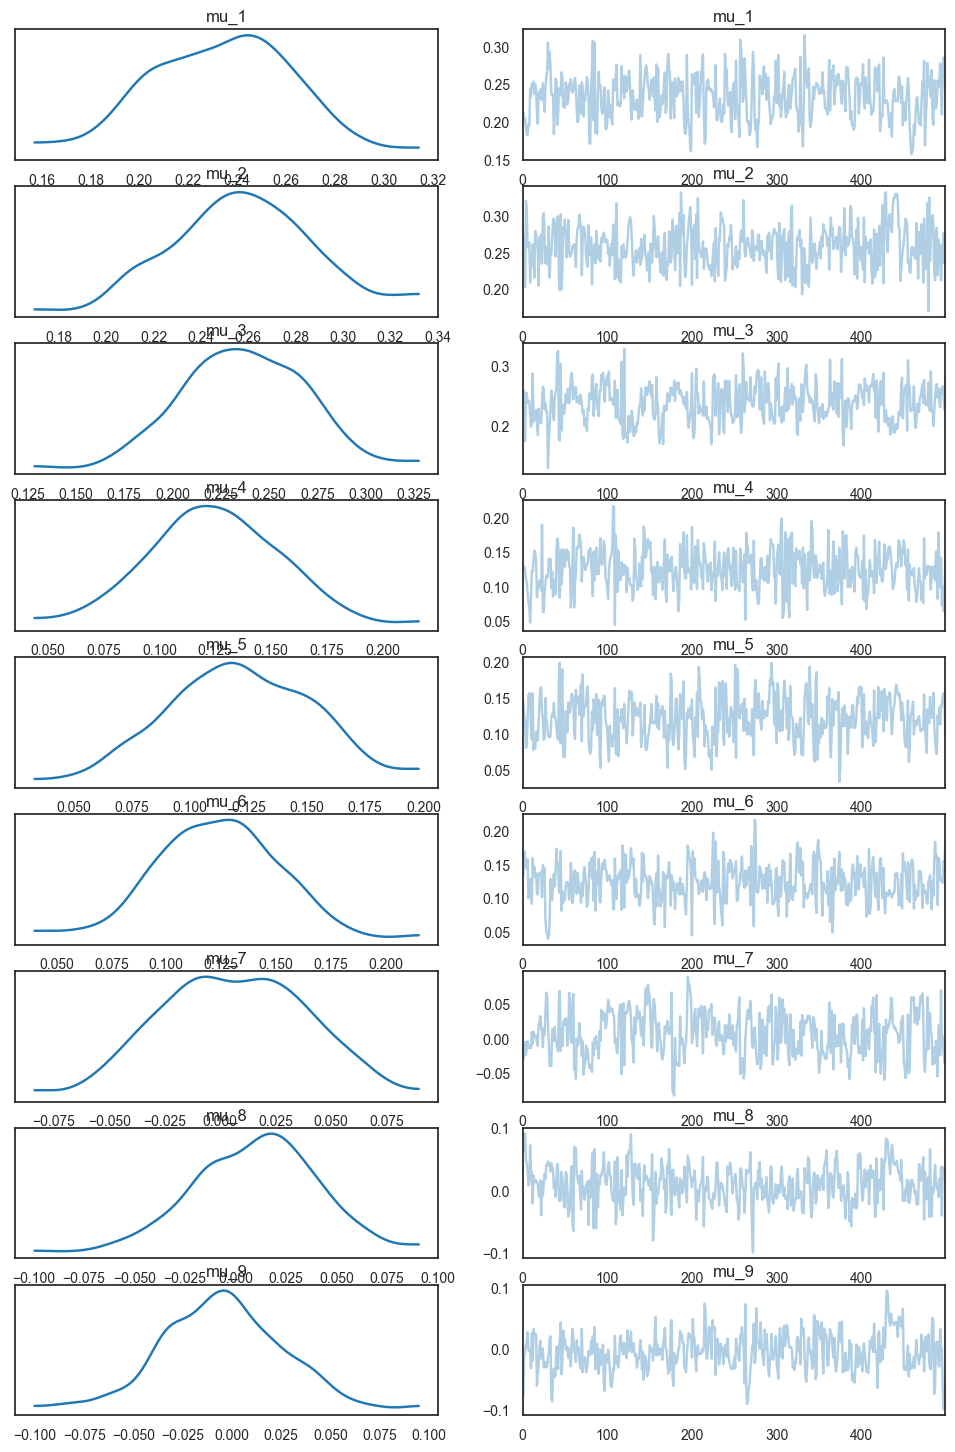

<Figure size 800x1000 with 0 Axes>

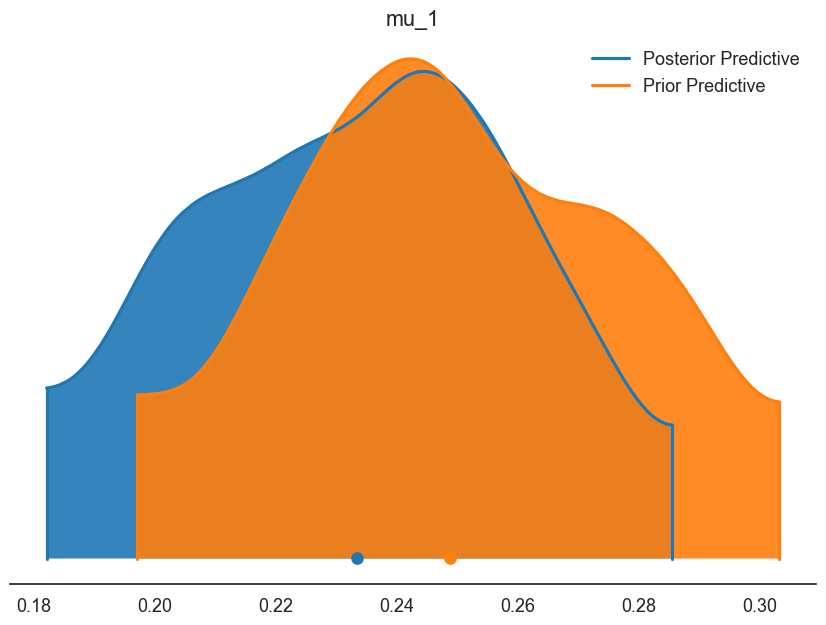

<Figure size 800x1000 with 0 Axes>

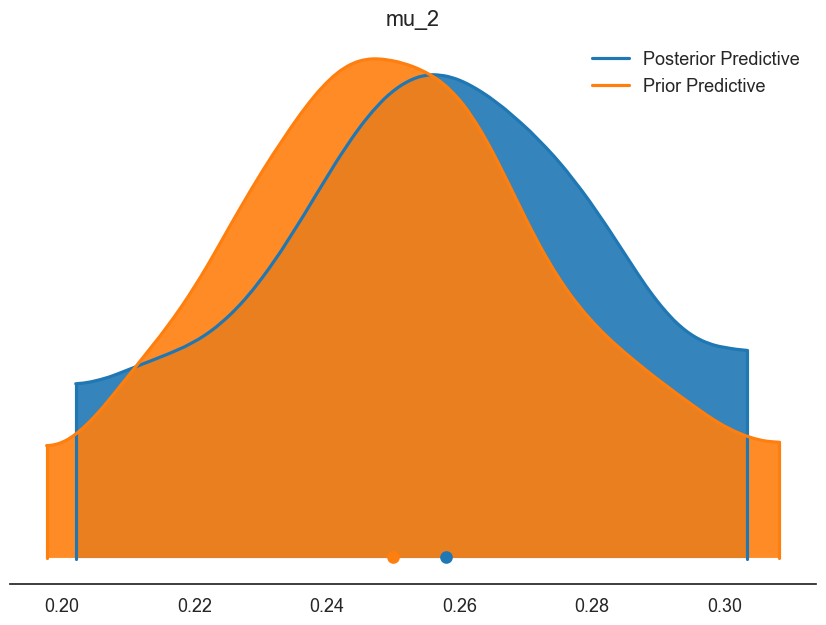

<Figure size 800x1000 with 0 Axes>

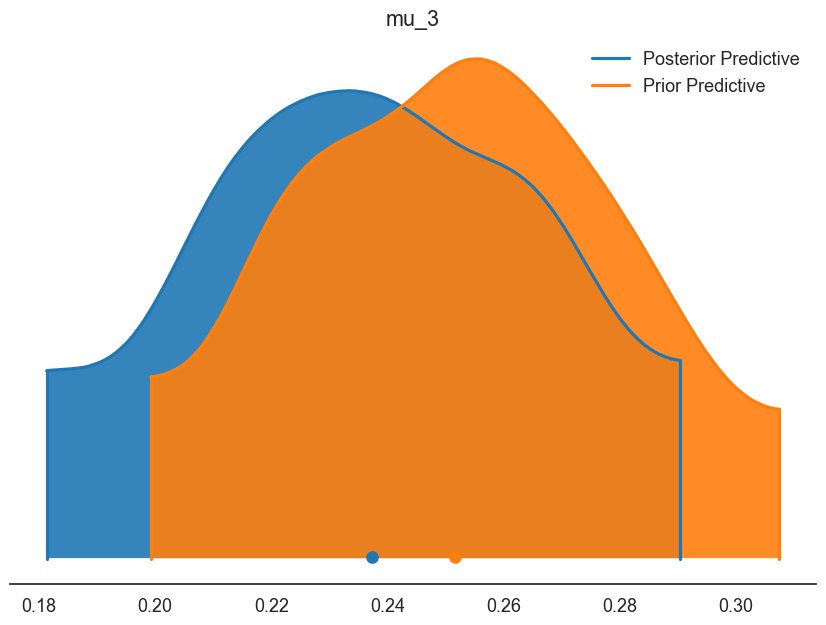

<Figure size 800x1000 with 0 Axes>

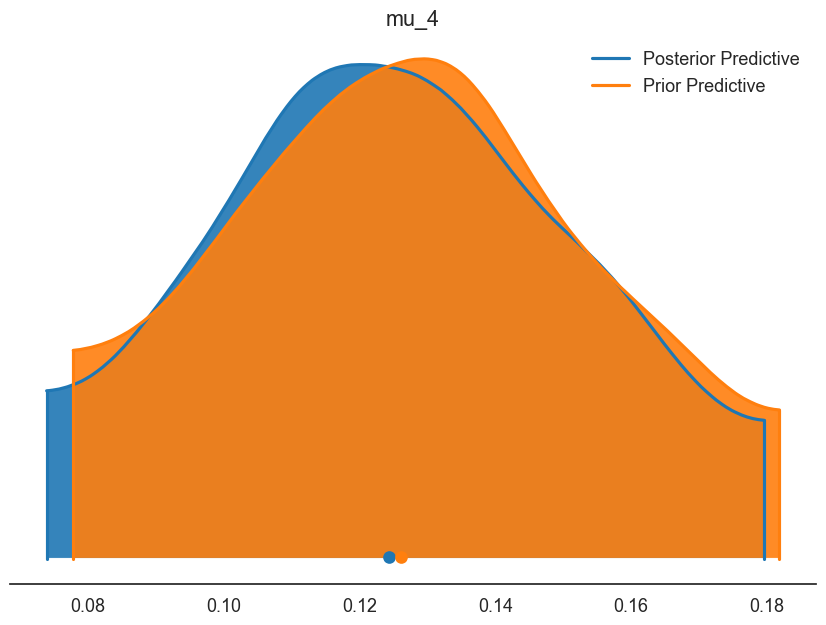

<Figure size 800x1000 with 0 Axes>

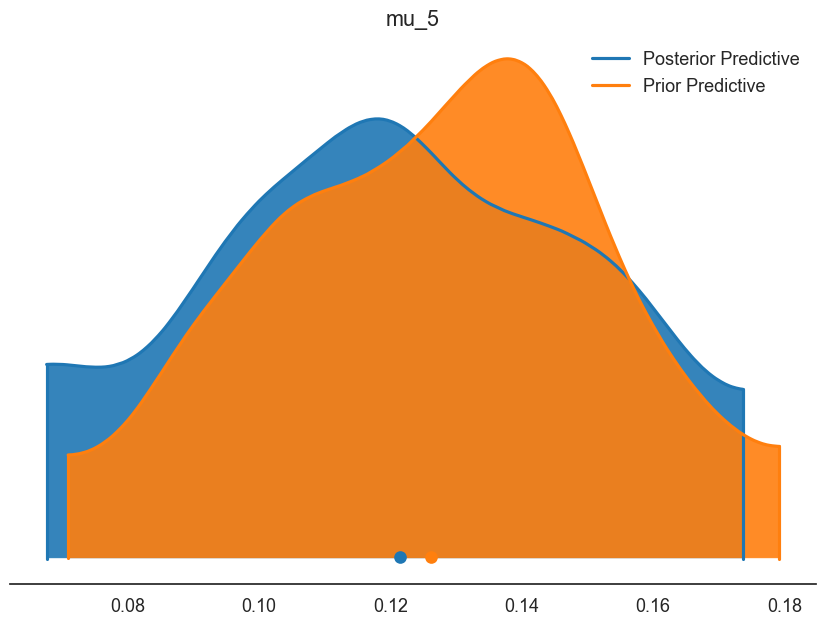

<Figure size 800x1000 with 0 Axes>

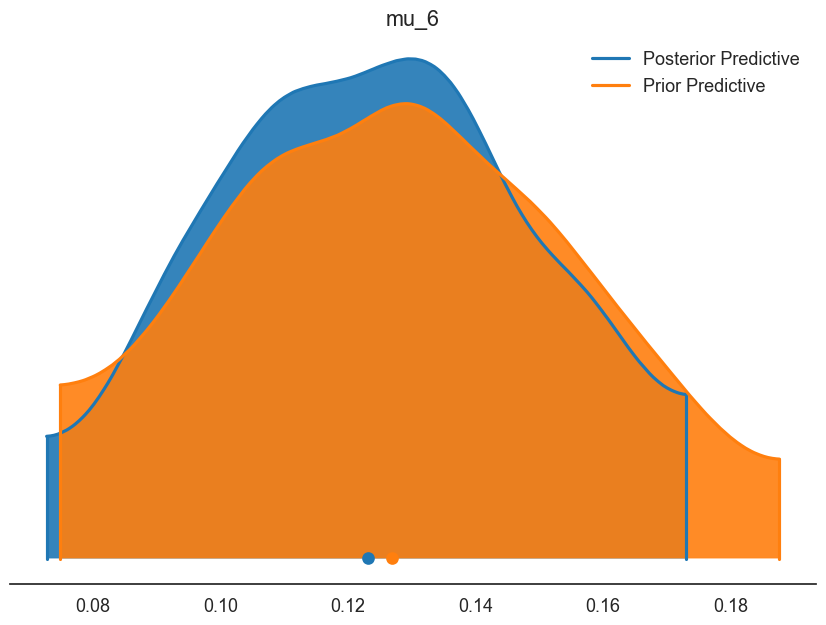

<Figure size 800x1000 with 0 Axes>

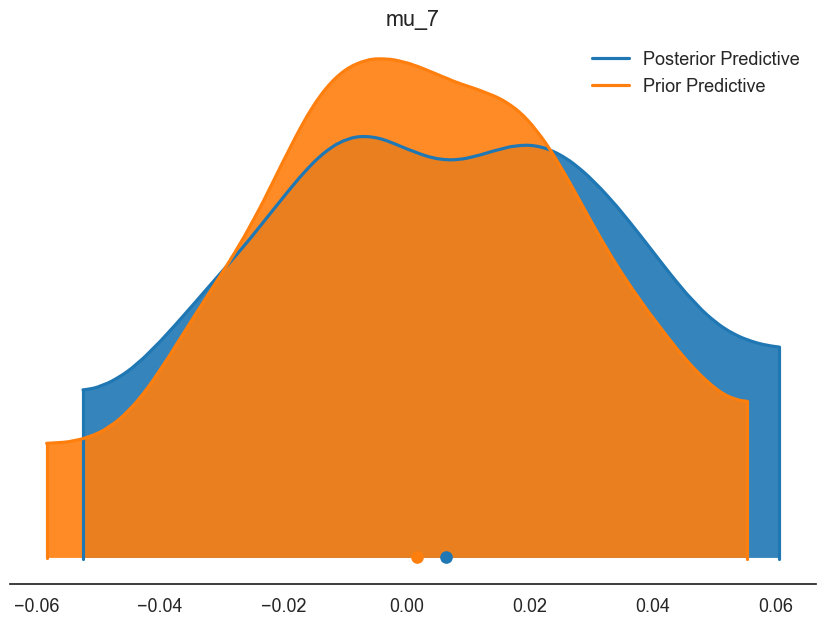

<Figure size 800x1000 with 0 Axes>

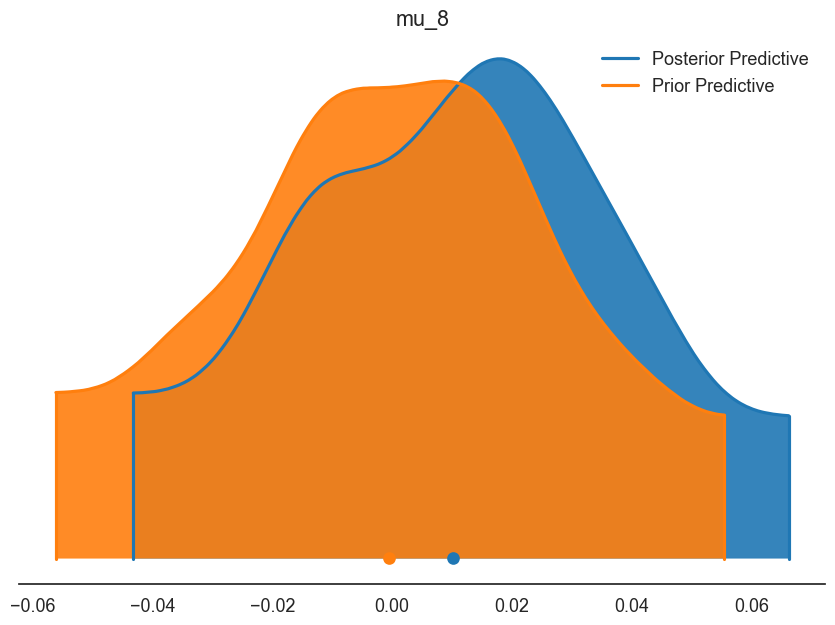

<Figure size 800x1000 with 0 Axes>

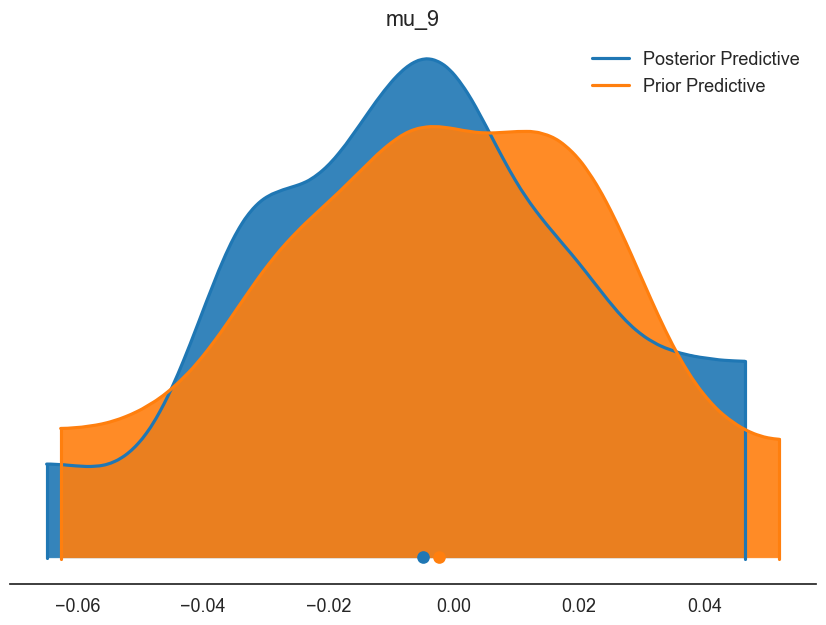

In [264]:
posterior_predictive = Predictive(pyro_model, posterior_samples)(test_list, num_layers, model,  u_shift, phi, obs_data , device)
plt.figure(figsize=(8,10))
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
###############################################TODO################################
# Plot and save the file for each parameter
###################################################################################
for i in range(len(test_list)):
    plt.figure(figsize=(8,10))
    az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_' +str(i+1)],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    )


In [265]:
list_parameter = []
for index, (key, values) in enumerate(posterior_samples.items()):
    print("Prior mean: ", test_list[index]["normal"]["mean"], "Prior std: ", test_list[index]["normal"]["std"])
    print("Posterior mean: ",torch.mean(values), "Posterior std: ",torch.std(values))
    list_parameter.append(torch.mean(values).to(torch.float64))

Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.2335) Posterior std:  tensor(0.0287)
Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.2579) Posterior std:  tensor(0.0284)
Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.2374) Posterior std:  tensor(0.0309)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1244) Posterior std:  tensor(0.0287)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1214) Posterior std:  tensor(0.0300)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1230) Posterior std:  tensor(0.0276)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.0064) Posterior std:  tensor(0.0318)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.0101) Posterior std:  tensor(0.0300)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior mea

Setting Backend To: AvailableBackends.PYTORCH
Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy


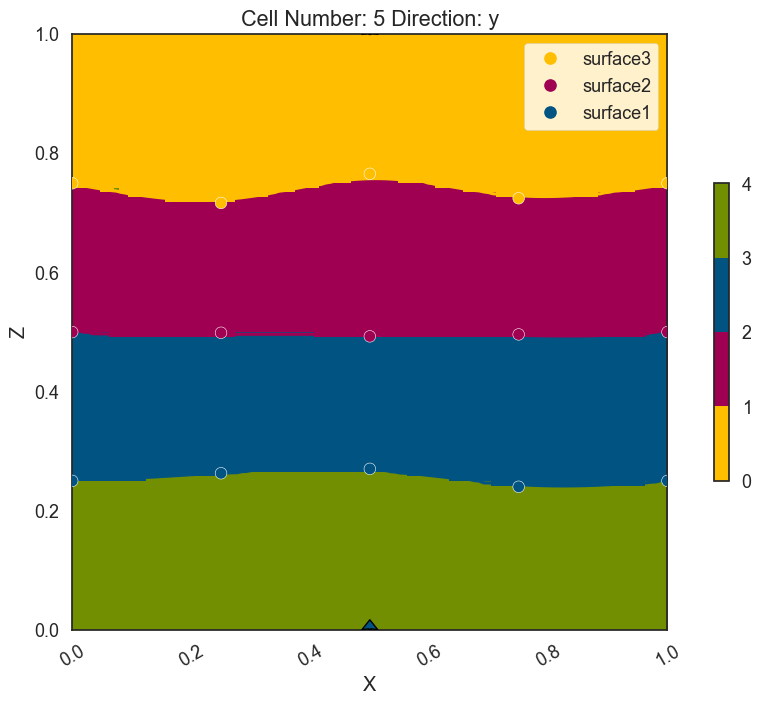

In [266]:
generate_final_model(geo_model=gempy_model, interpolation_input_=test_list, num_layers=num_layers,posterior_data=list_parameter)